In [1]:
!pip install -r requirements.txt

In [2]:
### function to print code
from IPython.display import Code as print_code
# print_code(dataset[1]['old_contents'], language='python')

### load dataset
import datasets
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# there is only train set
dataset = datasets.load_dataset("bigcode/commitpackft", "python")['train']

/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.1.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
/home/kirill/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Disclaimer: since I was more interested in the other parts of the assignment, I didn't spend much time on this part and have only done the basics.

#### Part 0. Authors' exploration

To start with I should mention that the authors of th paper have already done some interesting explorations of the data. Firstly, they used gpt-4 to categorise the code into categories (there is also a prompt in the paper for it):

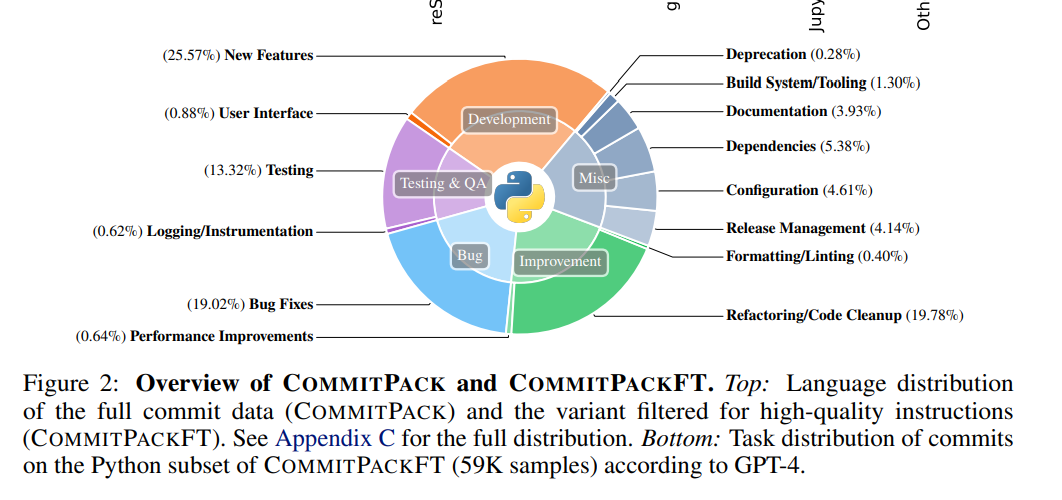

Of course it can be wrong at some points since it was done by gpt-4, but it should be mostly right.

It is worth mentioning that the biggest categories are New Features(25%), Bug Fixes(19%), Refactoring/Code Cleanup(19%) and Testing(13%).

Moreover, authors provide mean lengths in words as well as fitering in Appendix D:

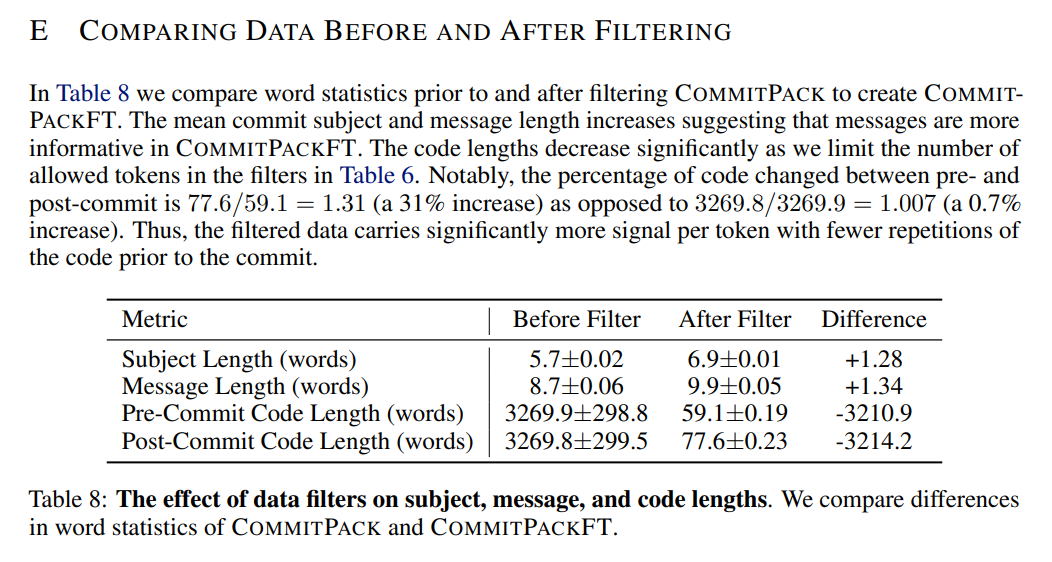

We can compare with it later. 

In the filtering it is worth mentioning that even fot the ```CommitPack``` vesion the authors already: 
1. The authors remove most popular (yet useless) commit messages like 'update'/'fix code' etc.
1. The authors leave only commits changing 1 file

    /*more*/

And for the ```CommitPachFT``` version they do a lot more. For example:
1. Only keep samples where the commit message can be split into more than 4 and less than 1000 space-separated words
1. Only keep samples where the message starts with an uppercase letter
1. Only keep samples where the lowercased commit message starts with any of the words in Table 7 (from me: has only 257 words)

    /*more*/

In my opinion 2nd and 3rd points are a little weird and might not be really suitable for real world use. 

In [3]:
len(dataset)

56025

In [4]:
### look at the random sample
dataset[125]

{'commit': '43efd1f110daa8f2f16475e4e6edbdf18ff28286',
 'old_file': 'linter.py',
 'new_file': 'linter.py',
 'old_contents': '#\n# linter.py\n# Linter for SublimeLinter3, a code checking framework for Sublime Text 3\n#\n# Written by Ben Edwards\n# Copyright (c) 2015 Ben Edwards\n#\n# License: MIT\n#\n\n"""This module exports the PugLint plugin class."""\n\nfrom SublimeLinter.lint import NodeLinter, util, highlight\n\n\nclass PugLint(NodeLinter):\n    """Provides an interface to pug-lint."""\n\n    cmd = \'pug-lint @ *\'\n    regex = r\'^.+?:(?P<line>\\d+)(:(?P<col>\\d+) | )(?P<message>.+)\'\n    multiline = False\n    tempfile_suffix = \'pug\'\n    error_stream = util.STREAM_BOTH\n    defaults = {\n        \'selector\': \'text.pug, source.pypug, text.jade\',\n        \'--reporter=\': \'inline\'\n    }\n    default_type = highlight.WARNING\n',
 'new_contents': '#\n# linter.py\n# Linter for SublimeLinter3, a code checking framework for Sublime Text 3\n#\n# Written by Ben Edwards\n# Copyri

In [5]:
dataset[55397]

{'commit': '1d652cac957f06afdad9fd64f617494e7f4821e4',
 'old_file': 'application.py',
 'new_file': 'application.py',
 'old_contents': '',
 'new_contents': '#!/usr/bin/env python\n# coding=utf-8\n# \n# Copyright 2015 cc98.org\n\nimport sys\nreload(sys)\nsys.setdefaultencoding("utf-8")\n\nimport os.path\nimport re\nimport memcache\nimport torndb\nimport tornado.httpserver\nimport tornado.ioloop\nimport tornado.options\nimport tornado.web\n\nfrom tornado.options import define, options\nfrom jinja2 import Environment, FileSystemLoader\n\n# Define a new command line option\ndefine("port", default = 80, type = int, help = "run on the given port")\ndefine("mysql_host", default = "mysql_host", help = "community database host")\ndefine("mysql_database", default = "mysql_database", help = "community database name")\ndefine("mysql_user", default = "mysql_db_user", help = "community database user")\ndefine("mysql_pwd", default = "mysql_db_pwd", help = "community database pwd")\n\nclass Application

Here there is just no ```old_cotents``` at all!

### Part 1. ```Subject``` and ```Message```

To start with I am not completely sure what's the difference metween ```subject``` and ```message``` and which one to use as an instruction, so let's check if they differ a lot. I found out that mostlythey differ by "'\n" so I will compare with ```strip()```: 

In [6]:
dataset_df = dataset.to_pandas()

# leave only those rows where subject != message
diff_subject_message = dataset_df[dataset_df['subject'].str.strip() != dataset_df['message'].str.strip()].reset_index(drop=True)

for row in diff_subject_message[['subject', 'message']].values[np.random.randint(0, len(diff_subject_message), 3)]:
    print('subject:', row[0])
    print('='*10)
    print('message:', row[1])
    print('='*50)
    print()

subject: Add 'Framework :: Django :: 1.9' to classifiers
message: Add 'Framework :: Django :: 1.9' to classifiers

https://travis-ci.org/RyanBalfanz/django-smsish/builds/105968596

subject: Add pyscopg2 to list of dependencies
message: Add pyscopg2 to list of dependencies


Former-commit-id: afed58eea17319b11e3fafc1ef45c7cdf590fac0
Former-commit-id: 257ed272462ca52cc15bae9040296ace91e15843 [formerly 19b9a870795fb176a9fb49b427a00b70fc6e2b35] [formerly 5b2ece2b396282c63c2902d6128e3a1f2c982708 [formerly 1a662bf08f6e4b81939fe16c4422c7201c9394f5]]
Former-commit-id: 2336bd3da92c144e041fba0c6d8a06f8c5beb9d3 [formerly e493e91f63a6989ea1b5c3add83dec0a8a4de16b]
Former-commit-id: a778516564b1489efffbb822760e23ead82c4467

subject: Test for new data loader
message: TST: Test for new data loader

Just a start, should probably add a more detailed test later.




As I was expecting - ```subject``` is basically smaller/has less information than ```message```. Sometimes we get commit names and sometimes infor about purpose - fix/change/add etc.. Let's compare the lengths:
 

subject(words): 	min: 4 	max: 75 	mean: 7.209 	median: 6.0 	95%: 12.0 	99%: 18.0
message(words): 	min: 5 	max: 494 	mean: 9.965 	median: 7.0 	95%: 27.0 	99%: 58.0
If we look only on the ones that differ:
subject(words): 	min: 4 	max: 75 	mean: 7.677 	median: 7.0 	95%: 14.0 	99%: 24.0
message(words): 	min: 5 	max: 494 	mean: 21.623 	median: 15.0 	95%: 58.0 	99%: 107.0


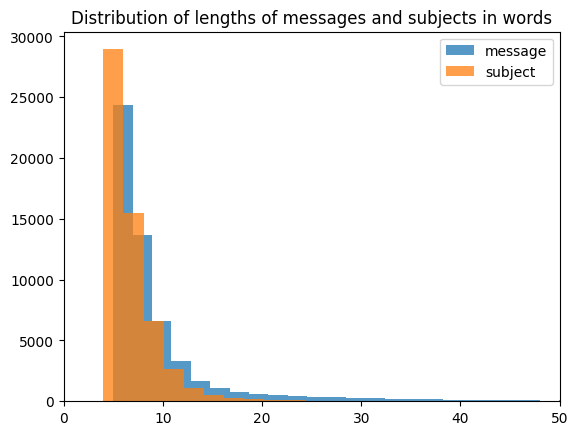

In [7]:
def print_stats(df, col):
    lens = df[col].apply(lambda x: len(x.split()))
    values = np.min(lens), np.max(lens), np.mean(lens), np.median(lens), np.percentile(lens, 95), np.percentile(lens, 99)
    print(f'{col}(words):', '\tmin:', values[0], '\tmax:', values[1], '\tmean:', round(values[2], 3), 
          '\tmedian:', values[3], '\t95%:', values[4], '\t99%:', values[5])


def plot_hist(df, col, lim, bins_num):
    lens = df[col].apply(lambda x: len(x.split()))
    plt.xlim(0, lim)
    plt.hist(lens, bins=bins_num, alpha=0.75)


subj_values = print_stats(dataset_df, 'subject')
msg_values = print_stats(dataset_df, 'message')

print('='*50)
print('If we look only on the ones that differ:')


subj_values = print_stats(diff_subject_message, 'subject')
msg_values = print_stats(diff_subject_message, 'message')

plot_hist(dataset_df, 'message', 50, 250)
plot_hist(dataset_df, 'subject', 50, 35)
plt.legend(['message', 'subject'])
plt.title('Distribution of lengths of messages and subjects in words')
plt.show()

We can see that there are in fact more longer messages than subjects. If we don't separate the ones that differ and look at the whole dataset - the difference is almost unnoticable - mean length is 7.2 and 9.9 words, while median is 6 and 7.

If we look only on the ones that differ - the difference is more significant - mean length is 7.6 and 21.62, while median is 7 and 15 (more than twice more!). 

My guess is that if the author uses message (i.e does not leave it the same as subject) - he/she has more to say about the commit and therefore the message is quite longer.

Even though authors already explored this datasaet with gpt-4, I'm still interested in creating a wordcloud of subjects to compare.:

[]

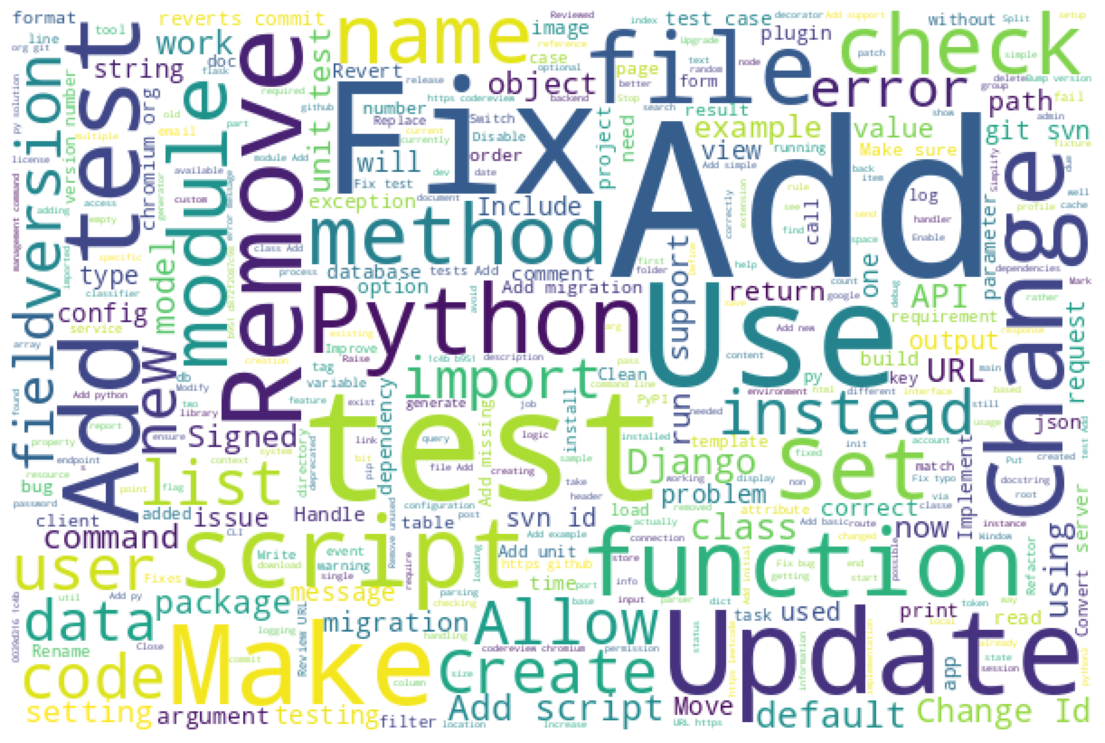

In [8]:
import wordcloud

wordcloud_notes = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=120, max_words=5000,
                      width = 600, height = 400,
                      background_color='white').generate("".join(dataset_df["message"]))
fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(wordcloud_notes, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud_notes)
plt.plot()

Here we basically see closely the same as gpt-4 said (fix, add_test, remove, mathod_check, etc).

### Part 2. The code itself

old_contents(words): 	min: 0 	max: 402 	mean: 57.11 	median: 56.0 	95%: 136.0 	99%: 172.0
new_contents(words): 	min: 0 	max: 424 	mean: 91.369 	median: 84.0 	95%: 187.0 	99%: 258.0


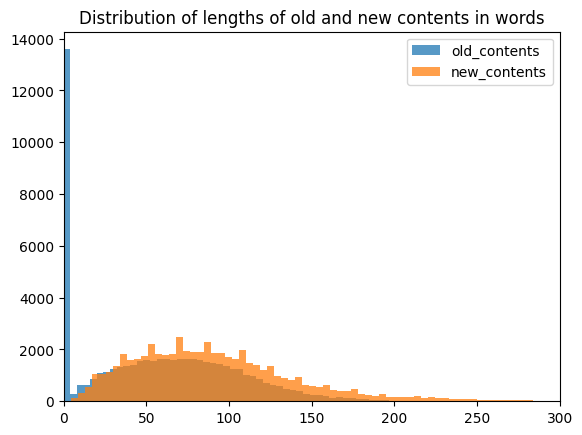

In [9]:
print_stats(dataset_df, 'old_contents')
print_stats(dataset_df, 'new_contents')

plot_hist(dataset_df, 'old_contents', 300, 100)
plot_hist(dataset_df, 'new_contents', 300, 100)
plt.legend(['old_contents', 'new_contents'])
plt.title('Distribution of lengths of old and new contents in words')
plt.show()

Here it is interesting to notice that we have 14k out of 56k (~25%) commits that have no ```old_content``` at all!!

In [10]:
dataset_df[dataset_df['old_contents'].apply(lambda x: len(x.split())) == 0][['old_contents', 'message', 'new_contents']]

,old_contents,message,new_contents
444,,test: Create stub of fit testing\n,"""""""\nThis module contains tests of code from t..."
508,,Fix import race condition on CI\n,# The main Flask application needs to imported...
667,,Write three functions to begin the feature to ...,'''\nUtilities to search files and retain meta...
685,,Add intial tests for decorators.\n,from name.decorators import jsonp\nfrom mock i...
911,,Add initial setup for solution\n,"class Pig_latin(object):\n vowels = [""a"", ""e""..."
...,...,...,...
55349,,Add (failing) Python command line parsing tests\n,import px_commandline\n\n\ndef test_get_comman...
55397,,Add some necessary things to run the app\n,#!/usr/bin/env python\n# coding=utf-8\n# \n# C...
55400,,Add the method to prettify the time displayed.\n,"class Filters():\n\t""""""\n\tGet a datetime inst..."
55611,,Add tests for init and push\n,import pytest\nfrom stack import Element\nfrom...


Seems weird.. But maybe it is intentional - this is basicall a setting NL->Code.

Looking on the pure stars, the new code is longer than the old one (57 vs 91 words average). Since there are a lot of empty ```old_ontents```, but also, for example, 25% of the samples are new features (according to gpt-4 by the authors)

### Part 3. ```licence``` and ```repos```

Let's study used licences and repos.

In [11]:
dataset_df['license'].value_counts()

license
mit             26394
bsd-3-clause     9827
apache-2.0       9819
agpl-3.0         4380
bsd-2-clause     2975
lgpl-2.1          821
isc               543
mpl-2.0           528
unlicense         389
cc0-1.0           205
artistic-2.0       85
epl-1.0            31
unknown            28
Name: count, dtype: int64

Good to see that the authors (almost) have not used any repos without any/unknown license.

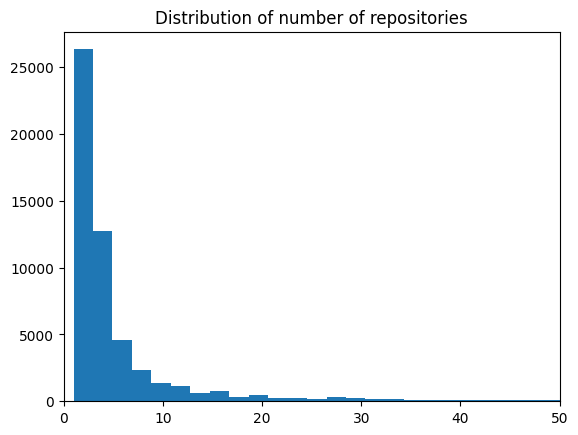

In [12]:
### Repositories:
lens = dataset_df['repos'].apply(lambda x: len(x.split(',')))
plt.xlim(0, 50)
plt.hist(lens, bins=1000)
plt.title('Distribution of number of repositories')
plt.show()

Actually a substantial part of the commits are duplicated in different repos - surprising to me. 

### Part 4. Let's read some samples!

In [13]:
SAMPLE_NUM = 129
print(dataset[SAMPLE_NUM]['subject'], "|", dataset[SAMPLE_NUM]['message'])
print_code(dataset[SAMPLE_NUM]['old_contents'], language='python')

Add parallelizing code to build | Add parallelizing code to build



#!/usr/bin/env python3
from manager import Manager

manager = Manager()


@manager.command
def build(threads=1):
    print("Starting a build with %d threads ..." % threads)

@manager.command
def clean():
    pass

if __name__ == '__main__':
    manager.main()

In [14]:
print_code(dataset[SAMPLE_NUM]['new_contents'], language='python')

#!/usr/bin/env python3
from manager import Manager
from multiprocessing import Pool

manager = Manager()


def func(period):
    from time import sleep
    sleep(period)


@manager.command
def build(threads=1):
    pool = Pool(threads)
    print("Starting a build with %d threads ..." % threads)
    pool.map(func, [1, 1, 1, 1, 1])


@manager.command
def clean():
    pass


if __name__ == '__main__':
    manager.main()

A simple and yet a good example of adding new feature - parallelization of the code.

Here is an example when there is empty ```old_content```:

In [15]:
SAMPLE_NUM = 55397
print(dataset[SAMPLE_NUM]['subject'], "|", dataset[SAMPLE_NUM]['message'])
print_code(dataset[SAMPLE_NUM]['old_contents'], language='python')

Add some necessary things to run the app | Add some necessary things to run the app



In [16]:
print_code(dataset[SAMPLE_NUM]['new_contents'], language='python')

#!/usr/bin/env python
# coding=utf-8
# 
# Copyright 2015 cc98.org

import sys
reload(sys)
sys.setdefaultencoding("utf-8")

import os.path
import re
import memcache
import torndb
import tornado.httpserver
import tornado.ioloop
import tornado.options
import tornado.web

from tornado.options import define, options
from jinja2 import Environment, FileSystemLoader

# Define a new command line option
define("port", default = 80, type = int, help = "run on the given port")
define("mysql_host", default = "mysql_host", help = "community database host")
define("mysql_database", default = "mysql_database", help = "community database name")
define("mysql_user", default = "mysql_db_user", help = "community database user")
define("mysql_pwd", default = "mysql_db_pwd", help = "community database pwd")

class Application(tornado.web.Application):
	def __init__(self):
		settings = dict(

		)

		handlers = [
			(),
		]

		tornado.web.Application.__init__(self, handlers, settings)

		# Have one global connection to the blog DB  across all the handlers
		self.db = torndb.Connection(

		)

		# Have one global session controller


		# Have one global memcache controller
		self.mc = memcache.Client(["127.0.0.1:11211"]])


def main():
	tornado.options.parse_command_line()
	httpserver = tornado.httpserver.HTTPServer(Application())
	httpserver.listen(options.port)
	tornado.ioloop.IOLoop.instance().start()

if __name__ = "__main__": 
	main()

It seems quite long and the desctiption (```Add some necessary things to run the app```) does not seems like enought to write so many lines! I would not be able to do it myself for example.

### Part 5. Conclusion

Overall, the dataset is cleaned well for the data that has been automatically scratched. However, even the cleanest 56k of samples have a lot of unclear instrucions in the comments or task that are too hard (not enough infoation and details).

This dataset can be used for the tasks that require a lot of a-little-noisy data. Afaik for fine-tuning this days you don't need a lot of data (like 50k) and you can work with hundreds of samples that can be generated or written by humans.

Also, probably if you want to have a model that will be able to code in different settings and languages - you probably want to have a lot of data and this dataset can be a good start. 